# Prediction of conversion within 7 days with neural network model

## 1. load data

In [1]:
from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery Client
client = bigquery.Client()

# Query to fetch data 
query = """
SELECT 
  event_date,
  event_timestamp,
  user_pseudo_id,
  event_name,
  
  ecommerce.total_item_quantity AS total_item_quantity,
  ecommerce.purchase_revenue_in_usd AS purchase_revenue_in_usd,
  ecommerce.purchase_revenue AS purchase_revenue,
  ecommerce.unique_items AS unique_items,
  ecommerce.transaction_id AS transaction_id,

  geo.country AS country,
  geo.city AS city,

  -- Flatten nested 'traffic_source' fields
  traffic_source.medium AS traffic_medium,
  traffic_source.source AS traffic_source

FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202011*`
WHERE event_date BETWEEN '20201101' AND '20201131'
"""
query_job = client.query(query)

# Load data into a pandas DataFrame
df = query_job.to_dataframe()

# Convert event_date to datetime
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')

## 2.1 Feature Engineering: Create derived features

In [3]:
def add_conversion_features(df):
    
    # Identify conversion
    df['is_conversion'] = df['purchase_revenue'] > 0   

    # Sort the DataFrame by user_pseudo_id and event_date
    df = df.sort_values(by=['user_pseudo_id', 'event_date']).reset_index(drop=True)

    # Create a cumulative conversion flag, Initialize 'last_conversion_date' with NaT for non-conversions and event_date for conversions
    df['last_conversion_date'] = pd.NaT
    df.loc[df['is_conversion'], 'last_conversion_date'] = df.loc[df['is_conversion'], 'event_date']

    # Forward-fill the 'last_conversion_date' for each user
    df['last_conversion_date'] = df.groupby('user_pseudo_id')['last_conversion_date'].ffill()

    # Calculate whether the event is within 7 days of the last conversion. Ensure 'last_conversion_date' and 'event_date' are in datetime format
    df['last_conversion_date'] = pd.to_datetime(df['last_conversion_date'])
    df['event_date'] = pd.to_datetime(df['event_date'])

    # Calculate the difference in days between 'event_date' and 'last_conversion_date'
    df['days_since_conversion'] = (df['event_date'] - df['last_conversion_date']).dt.days

    # Identify events within 7 days of the last conversion
    df['conversion_within_7_days'] = (
        (df['last_conversion_date'].notna()) &  # Ensure a conversion exists
        (df['days_since_conversion'] >= 0) &   # Ensure non-negative window
        (df['days_since_conversion'] <= 7)     # Within 7 days
    )
    
    # Clean up temporary columns
    df.drop(columns=['last_conversion_date', 'days_since_conversion', 'traffic_medium', 'traffic_source' ], inplace=True)
    
    return df

df = add_conversion_features(df)

print(df.info())

print(type(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472712 entries, 0 to 1472711
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  Int64         
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   purchase_revenue_in_usd   2054 non-null     float64       
 6   purchase_revenue          1998 non-null     float64       
 7   unique_items              144696 non-null   Int64         
 8   transaction_id            245751 non-null   object        
 9   country                   1472712 non-null  object        
 10  city                      1472712 non-null  object        
 11  is_conversion             1472712 non-null  bool  

## 2.2 Session based features

In [4]:
def add_session_features(df):    
    
    # Proportion of Specific Events: Ratio of specific event types (e.g., "add_to_cart", "view_item") to total events.
    df['add_to_cart_ratio'] = df['event_name'].eq('add_to_cart').groupby(df['user_pseudo_id']).transform('mean')
    df['view_item_ratio'] = df['event_name'].eq('view_item').groupby(df['user_pseudo_id']).transform('mean')
    
    # Define session ID using event_timestamp (30-minute of inactivity)
    df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='ms')
    df = df.sort_values(['user_pseudo_id', 'event_timestamp'])

    # Identify session breaks (30 minutes of inactivity), All events within a session (no 30-minute gap) share the same session ID.
    df['session_id'] = (df.groupby('user_pseudo_id')['event_timestamp']
                          .diff()
                          .gt(pd.Timedelta(minutes=30))
                          .cumsum())

    # Combined session-based feature aggregation
    session_features = (
        df.groupby(['user_pseudo_id', 'session_id'])
        .agg(
            session_duration=('event_timestamp', lambda x: (x.max() - x.min()).total_seconds() if len(x) > 1 else 0),
            session_event_count=('event_name', 'count')
        )
        .reset_index()  # Reset index to preserve session-level details
    )

    # Aggregate session-level data into user-level features
    user_session_features = (
        session_features.groupby('user_pseudo_id')
        .agg(
            total_sessions=('session_id', 'count'),
            average_session_duration=('session_duration', 'mean'),
            total_session_events=('session_event_count', 'sum'),
            average_session_events=('session_event_count', 'mean')
        )
        .reset_index()
    )
    
    # Debugging: Confirm session_id exists in df
    if 'session_id' not in df.columns:
        raise ValueError("session_id was not added to df.")

    return df, session_features, user_session_features

# Apply the add_session_features function and reassign df
df, session_features, user_session_features = add_session_features(df)

print(df.info())

print("Columns in session_features:")
print(session_features.columns.tolist())

print(type(df))



<class 'pandas.core.frame.DataFrame'>
Index: 1472712 entries, 3 to 1472710
Data columns (total 16 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  datetime64[ms]
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   purchase_revenue_in_usd   2054 non-null     float64       
 6   purchase_revenue          1998 non-null     float64       
 7   unique_items              144696 non-null   Int64         
 8   transaction_id            245751 non-null   object        
 9   country                   1472712 non-null  object        
 10  city                      1472712 non-null  object        
 11  is_conversion             1472712 non-null  bool       

## 2.4 Aggregated features

In [5]:
def add_aggregates_features(df):
    # Total and average revenue per user
    user_aggregates = df.groupby('user_pseudo_id').agg(
        total_revenue=('purchase_revenue', 'sum'),
        average_revenue=('purchase_revenue', 'mean'),
        total_events=('event_name', 'count'),
        unique_event_types=('event_name', 'nunique'),
        active_days=('event_date', 'nunique')
    ).reset_index()
    
    df = df.merge(user_aggregates, on='user_pseudo_id', how='left')
    df = df.merge(user_session_features, on='user_pseudo_id', how='left')
    
    # Conversion rate (conversions/total events per user)
    df['conversion_rate'] = df['is_conversion'] / df['total_events']
    
    return df

df = add_aggregates_features(df)
print (df.info())

print("Columns in session_features:")
print(session_features.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472712 entries, 0 to 1472711
Data columns (total 26 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  datetime64[ms]
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   purchase_revenue_in_usd   2054 non-null     float64       
 6   purchase_revenue          1998 non-null     float64       
 7   unique_items              144696 non-null   Int64         
 8   transaction_id            245751 non-null   object        
 9   country                   1472712 non-null  object        
 10  city                      1472712 non-null  object        
 11  is_conversion             1472712 non-null  bool  

In [6]:
print(type(df))


<class 'pandas.core.frame.DataFrame'>


## 2.5 Behavioral features

In [7]:
def add_behavioral_features(df, session_features):
    # Create a copy of session_features to avoid in-place modification
    session_features_copy = session_features.copy()
    
    # Abandoned cart: Users who added items to the cart but didn’t purchase
    df['abandoned_cart'] = ((df['event_name'] == 'add_to_cart') &
                            ~(df['user_pseudo_id'].isin(df.loc[df['event_name'] == 'purchase', 'user_pseudo_id']))).astype(int)
    
    # Bounce rate: Sessions with only one event
    session_features_copy['is_bounce'] = (session_features_copy['session_event_count'] == 1).astype(int)
    bounce_rate = session_features_copy.groupby('user_pseudo_id').agg(
        bounce_rate=('is_bounce', 'mean')
    ).reset_index()
    
    # Merge bounce rate into the main DataFrame
    df = df.merge(bounce_rate, on='user_pseudo_id', how='left')
    
    # Consistency of Engagement: Standard deviation of active days per week
    active_days_weekly = df.groupby(['user_pseudo_id', df['event_date'].dt.isocalendar().week])['event_date'].count()
    df['engagement_consistency'] = active_days_weekly.groupby('user_pseudo_id').std().fillna(0)

    # Cart-to-Conversion Ratio: Ratio of "add_to_cart" events to "purchase" events
    add_to_cart = df[df['event_name'] == 'add_to_cart'].groupby('user_pseudo_id')['event_name'].count()
    purchases = df[df['event_name'] == 'purchase'].groupby('user_pseudo_id')['event_name'].count()
    df['cart_to_conversion_ratio'] = add_to_cart / purchases

    # Return both original and modified session_features
    return df, bounce_rate, session_features, session_features_copy

df, bounce_rate, session_features, session_features_copy = add_behavioral_features(df, session_features)

print(df.info())
print("Columns in session_features:")
print(session_features.columns.tolist())

print(type(df))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472712 entries, 0 to 1472711
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  datetime64[ms]
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   purchase_revenue_in_usd   2054 non-null     float64       
 6   purchase_revenue          1998 non-null     float64       
 7   unique_items              144696 non-null   Int64         
 8   transaction_id            245751 non-null   object        
 9   country                   1472712 non-null  object        
 10  city                      1472712 non-null  object        
 11  is_conversion             1472712 non-null  bool  

## 2.6 Temporal features

In [8]:
def add_temporal_features(df):
    # Calculate days since first event for each user
    df['days_since_first_event'] = (df['event_date'] - df.groupby('user_pseudo_id')['event_date'].transform('min')).dt.days

    # Days between consecutive events
    df['days_between_events'] = df.groupby('user_pseudo_id')['event_date'].diff().dt.days
    df['days_between_events'] = df['days_between_events'].fillna(0)  # Fill NaN for first event
    
    # Peak Activity Hour: Most frequent hour of the day when a user engages
    df['hour_of_day'] = df['event_timestamp'].dt.hour
    peak_hour = df.groupby('user_pseudo_id')['hour_of_day'].agg(pd.Series.mode)
    df = df.merge(peak_hour.rename('peak_hour'), on='user_pseudo_id', how='left')
    
    # Weekend Activity: Count or proportion of events occurring on weekends
    df['is_weekend'] = df['event_date'].dt.weekday >= 5
    weekend_activity = df.groupby('user_pseudo_id')['is_weekend'].mean()
    df = df.merge(weekend_activity.rename('weekend_activity'), on='user_pseudo_id', how='left')

    # Session Recency: Number of days since the last session for each user.
    df['days_since_last_session'] = (
        df['event_date'] - df.groupby('user_pseudo_id')['event_date'].transform('max')
    ).dt.days
    # Event Diversity Index: Ratio of unique event types to total events for a user.
    df['event_diversity_index'] = df['unique_event_types'] / df['total_events']
    
    return df

df = add_temporal_features(df)

print(df.info())

print("Columns in session_features:")
print(session_features.columns.tolist())

print(type(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472712 entries, 0 to 1472711
Data columns (total 38 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  datetime64[ms]
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   purchase_revenue_in_usd   2054 non-null     float64       
 6   purchase_revenue          1998 non-null     float64       
 7   unique_items              144696 non-null   Int64         
 8   transaction_id            245751 non-null   object        
 9   country                   1472712 non-null  object        
 10  city                      1472712 non-null  object        
 11  is_conversion             1472712 non-null  bool  

## 2.9 Revenue features

In [9]:
def add_revenue_features(df):
    # Revenue per Event: Total revenue divided by the number of events
    df['revenue_per_event'] = df['total_revenue'] / df['total_events']
    # High-Spender Flag: Flag for users whose total revenue exceeds a certain threshold (e.g., $500)
    df['is_high_spender'] = (df['total_revenue'] > 500).astype(int)
    
    return df
df = add_revenue_features(df)

print(df.info())

print("Columns in session_features:")
print(session_features.columns.tolist())

print(type(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472712 entries, 0 to 1472711
Data columns (total 40 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  datetime64[ms]
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   purchase_revenue_in_usd   2054 non-null     float64       
 6   purchase_revenue          1998 non-null     float64       
 7   unique_items              144696 non-null   Int64         
 8   transaction_id            245751 non-null   object        
 9   country                   1472712 non-null  object        
 10  city                      1472712 non-null  object        
 11  is_conversion             1472712 non-null  bool  

## 3.1 : Correlation analysis

In [10]:
# List of features to drop, these features have correlation more than 70%, so I chose one of them to drop. 
features_to_drop = ['purchase_revenue_in_usd', 'purchase_revenue', 'bounce_rate', 'total_sessions', 'total_session_events','total_revenue', 'unique_event_types' ]

# Drop the features from the DataFrame
df = df.drop(columns=features_to_drop)

print(df.info())

print("Columns in session_features:")
print(session_features.columns.tolist())

print(type(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472712 entries, 0 to 1472711
Data columns (total 33 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   event_date                1472712 non-null  datetime64[ns]
 1   event_timestamp           1472712 non-null  datetime64[ms]
 2   user_pseudo_id            1472712 non-null  object        
 3   event_name                1472712 non-null  object        
 4   total_item_quantity       20541 non-null    Int64         
 5   unique_items              144696 non-null   Int64         
 6   transaction_id            245751 non-null   object        
 7   country                   1472712 non-null  object        
 8   city                      1472712 non-null  object        
 9   is_conversion             1472712 non-null  bool          
 10  conversion_within_7_days  1472712 non-null  bool          
 11  add_to_cart_ratio         1472712 non-null  float6

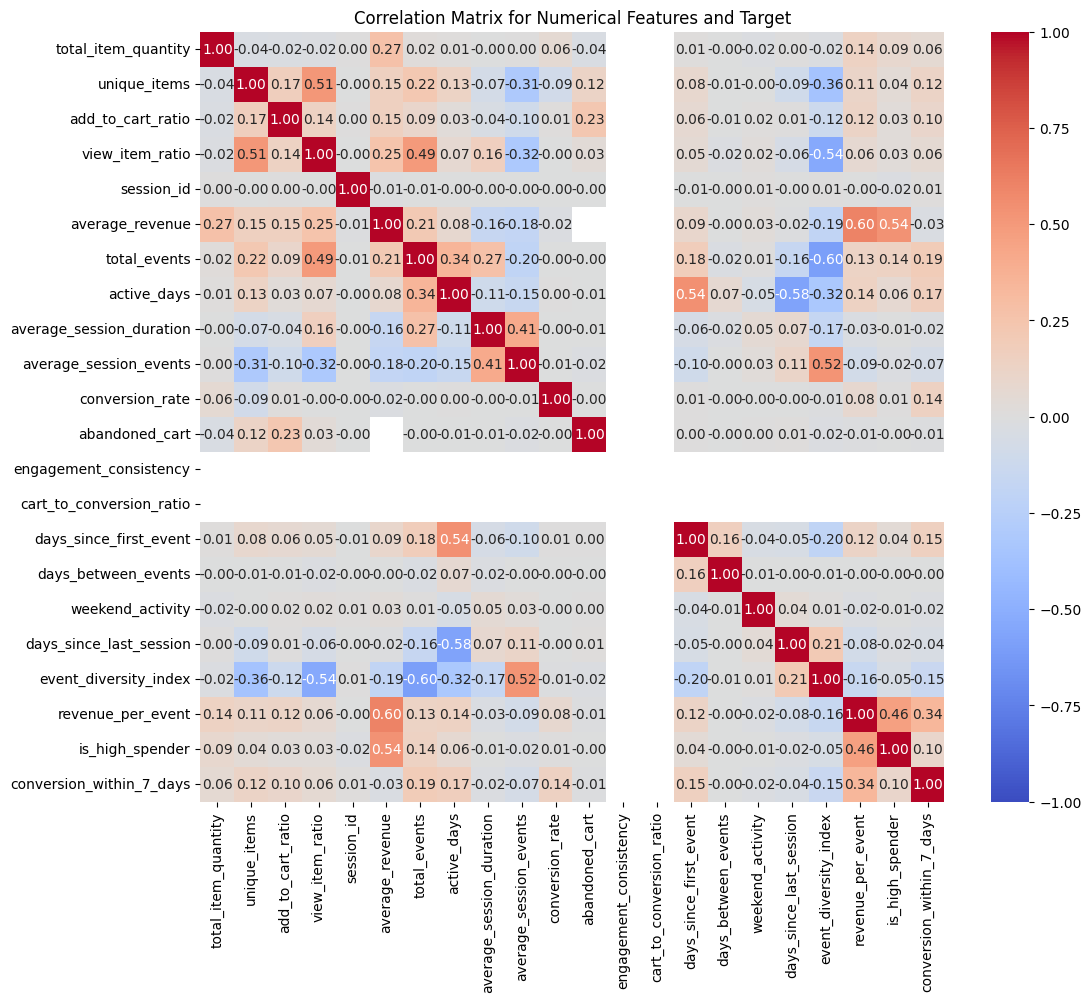

Highly Correlated Features (|correlation| > 0.8):


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure target variable and numerical features are defined
target = 'conversion_within_7_days'

# Extract numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

# Ensure to exclude non-predictive columns like IDs, timestamps, etc.
exclude_columns = ['event_date', 'event_timestamp', 'user_pseudo_id', 'transaction_id']
numerical_features = [col for col in numerical_features if col not in exclude_columns]

# Add the target to the list for correlation analysis
numerical_features_with_target = numerical_features + [target]

# Compute the correlation matrix
correlation_matrix = df[numerical_features_with_target].corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix for Numerical Features and Target")
plt.show()

# Identify highly correlated features (absolute correlation > 0.8) excluding self-correlation
threshold = 0.8
correlated_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display the highly correlated pairs
print("Highly Correlated Features (|correlation| > 0.8):")
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")


# 3.1 Create balanced dataset
- the reason for this is bsc df used to be a very imbalanced dataset, causing not enough data to train the "true" class, 95% of data is false class and causing F1 score of the model to be aorund 54%, and the precision/recall score for false is above 95%, but precision/recall score for true is around 50%, hence trying to create a balanced dataset

In [12]:
# Import necessary libraries
import pandas as pd

# Ensure the target variable is defined
target = 'conversion_within_7_days'

# Separate the original dataset into two subsets: True and False
df_true = df[df[target] == True]
df_false = df[df[target] == False]

# Sample 5000 rows from each subset
df_true_sampled = df_true.sample(n=10000, random_state=42)
df_false_sampled = df_false.sample(n=10000, random_state=42)

# Combine the two subsets to create a balanced dataset
df_balanced = pd.concat([df_true_sampled, df_false_sampled])

# Shuffle the combined dataset to mix the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new dataset
print(f"Balanced Dataset Shape: {df_balanced.shape}")
print("Class Distribution in Balanced Dataset:")
print(df_balanced[target].value_counts())

df = df_balanced

Balanced Dataset Shape: (20000, 33)
Class Distribution in Balanced Dataset:
conversion_within_7_days
False    10000
True     10000
Name: count, dtype: int64


# 3.2 Feature importance analysis - Random forest for feature importance
- Random Forest is interpretable, robust, and handles both categorical and numerical features well.
- It provides mean decrease impurity (MDI) or permutation importance, which can highlight key features effectively.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the DataFrame for Random Forest processing
df_rf = df.copy()

# Define features and target
target = 'conversion_within_7_days'
X = df_rf.drop(columns=[target, 'event_date', 'event_timestamp', 'user_pseudo_id', 'transaction_id'])
y = df_rf[target]

# Remove columns with all missing values
X = X.dropna(axis=1, how='all')

# Clean numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns
for col in numerical_features:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Clean categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    X[col] = X[col].astype(str)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocessor for numerical features (imputation + passthrough)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Replace NaN with the mean of each column
    ('passthrough', 'passthrough')               # No scaling required for Random Forest
])

# Preprocessor for categorical features (imputation + one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace NaN with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode categorical features
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Random Forest Classifier pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the Random Forest Classifier
rf_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = (
    list(numerical_features) +
    list(rf_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

# Extract feature importances
rf_model = rf_pipeline.named_steps['classifier']
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# plt.barh(feature_importances['Feature'], feature_importances['Importance'])
# plt.xlabel("Feature Importance")
# plt.ylabel("Feature")
# plt.title("Random Forest Feature Importances")
# plt.gca().invert_yaxis()
# plt.show()

print("Top Features:")
print(feature_importances.head(10))


Top Features:
                     Feature  Importance
17         revenue_per_event    0.294787
5            average_revenue    0.117210
6               total_events    0.081761
16     event_diversity_index    0.061095
8   average_session_duration    0.050817
3            view_item_ratio    0.048872
4                 session_id    0.044533
7                active_days    0.029547
9     average_session_events    0.027081
12    days_since_first_event    0.026708


In [23]:
# Check importance of specific features
specific_features = ['abandoned_cart', 'bounce_rate', 'days_since_first_event', 'days_between_events', 'event_name']
specific_importance = feature_importances[feature_importances['Feature'].isin(specific_features)]

# Print the importance of the selected features
print("Importance of Specific Features:")
print(specific_importance)


Importance of Specific Features:
                   Feature  Importance
11  days_since_first_event    0.031062
12     days_between_events    0.000712
10          abandoned_cart    0.000659


In [25]:
# Filter features with importance > 0.01
important_features = feature_importances[feature_importances['Importance'] > 0.005]

# Print the filtered features
print("Features with Importance > 0.0005:")
print(important_features)

# Optionally, save these features to a list for further use
selected_features = important_features['Feature'].tolist()
print("\nSelected Features for Further Use:")
print(selected_features)



Features with Importance > 0.0005:
                       Feature  Importance
14           revenue_per_event    0.304527
5              average_revenue    0.145585
6                 total_events    0.079144
8     average_session_duration    0.052674
3              view_item_ratio    0.046828
17       event_diversity_index    0.046612
4                   session_id    0.041361
11      days_since_first_event    0.031062
9       average_session_events    0.027458
2            add_to_cart_ratio    0.019211
7                  active_days    0.017202
16     days_since_last_session    0.014559
1                 unique_items    0.011758
13            weekend_activity    0.008173
15             is_high_spender    0.006474
0          total_item_quantity    0.005770
31  event_name_user_engagement    0.005296

Selected Features for Further Use:
['revenue_per_event', 'average_revenue', 'total_events', 'average_session_duration', 'view_item_ratio', 'event_diversity_index', 'session_id', 'days_since_

In [14]:
print(df_rf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   event_date                20000 non-null  datetime64[ns]
 1   event_timestamp           20000 non-null  datetime64[ms]
 2   user_pseudo_id            20000 non-null  object        
 3   event_name                20000 non-null  object        
 4   total_item_quantity       1158 non-null   Int64         
 5   unique_items              3733 non-null   Int64         
 6   transaction_id            5143 non-null   object        
 7   country                   20000 non-null  object        
 8   city                      20000 non-null  object        
 9   is_conversion             20000 non-null  bool          
 10  conversion_within_7_days  20000 non-null  bool          
 11  add_to_cart_ratio         20000 non-null  float64       
 12  view_item_ratio   

In [15]:
# only keep these selected features
# List of selected features
selected_features = [
    'revenue_per_event', 'average_revenue', 'total_events', 
    'average_session_duration', 'view_item_ratio', 'event_diversity_index', 
    'session_id', 'days_since_first_event', 'average_session_events', 
    'add_to_cart_ratio', 'active_days', 'days_since_last_session', 
    'unique_items', 'weekend_activity', 'is_high_spender', 
    'total_item_quantity'
]

# Filter the DataFrame to keep only the selected features
df_rf = df_rf[selected_features]

# Verify the shape of the new DataFrame
print("New DataFrame:", df_rf.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   revenue_per_event         20000 non-null  float64
 1   average_revenue           11106 non-null  float64
 2   total_events              20000 non-null  int64  
 3   average_session_duration  20000 non-null  float64
 4   view_item_ratio           20000 non-null  float64
 5   event_diversity_index     20000 non-null  float64
 6   session_id                20000 non-null  int64  
 7   days_since_first_event    20000 non-null  int64  
 8   average_session_events    20000 non-null  float64
 9   add_to_cart_ratio         20000 non-null  float64
 10  active_days               20000 non-null  int64  
 11  days_since_last_session   20000 non-null  int64  
 12  unique_items              3733 non-null   Int64  
 13  weekend_activity          20000 non-null  float64
 14  is_hig

## 4.1 Data splitting for neural network

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Step 1: Define Target Variable and Features
# Target variable: conversion_within_7_days
target = 'conversion_within_7_days'


selected_features = [
    'revenue_per_event', 'average_revenue', 'total_events', 
    'average_session_duration', 'view_item_ratio', 'event_diversity_index', 
    'session_id', 'days_since_first_event', 'average_session_events', 
    'add_to_cart_ratio', 'active_days', 'days_since_last_session', 
    'unique_items', 'weekend_activity', 'is_high_spender', 
    'total_item_quantity'
]

# create a copy of df just for neural network model
df.nn = df.copy()

# select features from random forest result
features = [col for col in df.columns if col in selected_features]

# Separate features (X) and target (y)
X = df.nn[features]
y = df.nn[target]

# Step 2: Data Splitting
# Split the data into training, validation, and test sets (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify=y: Ensures the class distribution of the target variable is preserved in the splits
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # Further splits the temporary dataset

# Step 3: Data Preprocessing
# Define numerical and categorical columns, scaling for numerical columns and encoding for categorical ones
numerical_columns = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns
categorical_columns = X.select_dtypes(include=['category', 'bool', 'object']).columns

# Preprocessor for numerical features: Impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Replaces missing values with the mean of each column
    ('scaler', StandardScaler())                 # Scaling: Standardizes the numerical features to have a mean of 0 and a standard deviation of 1
])

# Preprocessor for categorical features: Impute and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fills missing values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode, Converts categorical values into binary indicator variables
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

# Step 4: Final Pipeline
# Add preprocessor to a full pipeline
modeling_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Preprocessing step (scaling, encoding, etc.)
])

# Step 5: Fit Preprocessing Pipeline
# Fit the preprocessing pipeline only on training data
X_train_prepared = modeling_pipeline.fit_transform(X_train)

# Apply the preprocessing pipeline to validation and test data
X_val_prepared = modeling_pipeline.transform(X_val)
X_test_prepared = modeling_pipeline.transform(X_test)

# Step 6: Inspect Prepared Data
# Check the shape of the transformed data
print(f"Training data shape: {X_train_prepared.shape}")
print(f"Validation data shape: {X_val_prepared.shape}")
print(f"Test data shape: {X_test_prepared.shape}")

# Save prepared data for modeling
import joblib
joblib.dump((X_train_prepared, y_train, X_val_prepared, y_val, X_test_prepared, y_test), 'prepared_data.pkl')

Training data shape: (14000, 16)
Validation data shape: (3000, 16)
Test data shape: (3000, 16)


/var/tmp/ipykernel_202384/1887997509.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.nn = df.copy()


['prepared_data.pkl']

## 4.2 Neural network model build
- this is a feed forward neural network, data flows in one direction
- Why This model is chosen
- Tabular Data: Feedforward neural networks are commonly used for structured datasets, especially after preprocessing and feature engineering.
- Binary Classification: The sigmoid activation in the output layer ensures the model produces probabilities for the two classes.
- Overfitting Prevention: Dropout layers and early stopping help mitigate overfitting.Why This Architecture Was Chosen

In [17]:
print(f"Training data size: {X_train.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]} per sample")

import psutil
print(f"Memory usage during training: {psutil.virtual_memory().percent}%")



Training data size: 14000 samples
Number of features: 16 per sample
Memory usage during training: 16.0%


- based on this output , I decided to start with 50 to 100 epochs and use early stopping to prevent overfitting
- use batch size 32 or 64
- neurons in layer: 64 to 32

In [18]:
# 1. import libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2. neural network architecture

# Build the Neural Network Model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_prepared.shape[1],)),  # Input layer with 64 neurons
    Dropout(0.2),  # Dropout for regularization, randomly deactivates 20% of the neurons during training to prevent overfitting
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons, ReLU rectified linear unit activation, it introduces non-linearity and helps the model learn complex patterns
    Dropout(0.2),  # Dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer uses sigmoid activation function, suitable for binary classification, outputs a probability between 1 and 0
])

# Compile the Model
nn_model.compile(
    optimizer='adam',  # this dataset has many features, and Adam is efficient and adapts well to the complexities of training neural networks.
    loss='binary_crossentropy',  # Binary crossentropy is suitable for binary classification tasks, as it compares the predicted probability to the actual binary label and calculates the loss accordingly.
    metrics=['accuracy']  # Metric to monitor during training
)

# Display the model architecture
nn_model.summary()

2025-01-20 20:50:44.442996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 20:50:46.187119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-01-20 20:50:46.187335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1088      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


2025-01-20 20:50:47.304672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-01-20 20:50:47.304779: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-20 20:50:47.304817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20250107-233026): /proc/driver/nvidia/version does not exist
2025-01-20 20:50:47.305747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable the

In [20]:
from scipy.sparse import issparse
from tensorflow.keras.callbacks import EarlyStopping

# X_train_prepared and X_val_prepared are already dense NumPy arrays
# Convert sparse matrices to dense arrays (if needed)
if issparse(X_train_prepared):
    X_train_prepared = X_train_prepared.toarray()

if issparse(X_val_prepared):
    X_val_prepared = X_val_prepared.toarray()

# Convert y_train and y_val from pandas.Series to NumPy arrays
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
y_val = y_val.values if isinstance(y_val, pd.Series) else y_val

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Train the Neural Network
history = nn_model.fit(
    X_train_prepared, y_train,  # Training data
    validation_data=(X_val_prepared, y_val),  # Validation data
    epochs=50,  # Maximum number of epochs
    batch_size=32,  # Number of samples per batch
    callbacks=[early_stopping],  # Early stopping callback
    verbose=1  # Print training progress
)


Epoch 1/50
438/438 [==============================] - 2s 3ms/step - loss: 0.3464 - accuracy: 0.8539 - val_loss: 0.2047 - val_accuracy: 0.9373
Epoch 2/50
438/438 [==============================] - 1s 3ms/step - loss: 0.2121 - accuracy: 0.9304 - val_loss: 0.1777 - val_accuracy: 0.9470
Epoch 3/50
438/438 [==============================] - 1s 3ms/step - loss: 0.1954 - accuracy: 0.9374 - val_loss: 0.1703 - val_accuracy: 0.9463
Epoch 4/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1859 - accuracy: 0.9408 - val_loss: 0.1682 - val_accuracy: 0.9473
Epoch 5/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1832 - accuracy: 0.9408 - val_loss: 0.1623 - val_accuracy: 0.9483
Epoch 6/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1776 - accuracy: 0.9433 - val_loss: 0.1616 - val_accuracy: 0.9493
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.1751 - accuracy: 0.9431 - val_loss: 0.1594 - val_accuracy: 0.9490
Epoch 

## 4.3 Evaluate neural network model

In [22]:
# Evaluate on Validation Data
y_pred_prob_nn = nn_model.predict(X_val_prepared).flatten()  # Predicted probabilities
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification Report
print("Classification Report (Neural Network):")
print(classification_report(y_val, y_pred_nn))

94/94 [==============================] - 0s 2ms/step
Classification Report (Neural Network):
              precision    recall  f1-score   support

       False       1.00      0.90      0.95      1500
        True       0.91      1.00      0.95      1500

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



In [24]:
# AUC-ROC
auc_roc_nn = roc_auc_score(y_val, y_pred_prob_nn)
print("AUC-ROC (Neural Network):", auc_roc_nn)

AUC-ROC (Neural Network): 0.9739975555555554


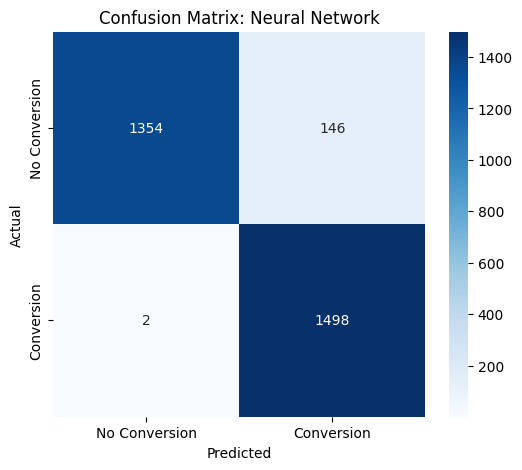

In [25]:
# Confusion Matrix
conf_matrix_nn = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Conversion', 'Conversion'], yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix: Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

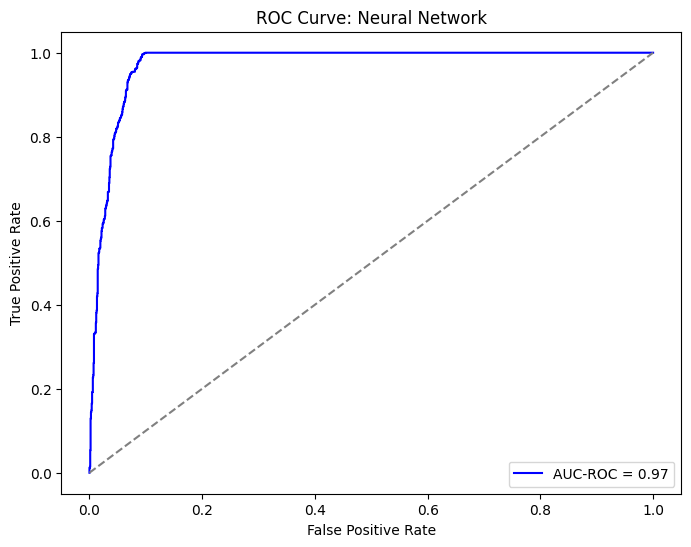

In [26]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_nn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc_nn:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference line for random guess
plt.title('ROC Curve: Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 4.4 Hyperparameter optimization for neural networks

In [32]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# Define the model-building function
def build_nn_model(hp):
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32), 
        activation=hp.Choice('activation_1', ['relu', 'tanh']),
        input_shape=(X_train_prepared.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=16, max_value=64, step=16), 
        activation=hp.Choice('activation_2', ['relu', 'tanh'])
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Optional third hidden layer
    if hp.Boolean('add_third_layer'):
        model.add(Dense(
            units=hp.Int('units_3', min_value=8, max_value=32, step=8),
            activation=hp.Choice('activation_3', ['relu', 'tanh'])
        ))
        model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with tunable learning rate and optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_nn_model,
    objective='val_loss',
    max_epochs=50,  # Maximum number of epochs per model
    factor=3,  # Reduction factor for Hyperband
    directory='my_dir',
    project_name='nn_tuning_improved'
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Search for the best hyperparameters
tuner.search(
    X_train_prepared, y_train,
    validation_data=(X_val_prepared, y_val),
    epochs=50,  # Max epochs for each model
    batch_size=256,  # Fixed batch size here; hyperparameter inside `build_nn_model`
    callbacks=[early_stopping],
    verbose=1
)

# Display the results
tuner.results_summary()

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Trial 90 Complete [00h 00m 15s]
val_loss: 0.23740226030349731

Best val_loss So Far: 0.1528633087873459
Total elapsed time: 00h 06m 14s
Results summary
Results in my_dir/nn_tuning_improved
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0073 summary
Hyperparameters:
units_1: 32
activation_1: relu
dropout_1: 0.2
units_2: 16
activation_2: relu
dropout_2: 0.2
add_third_layer: True
learning_rate: 0.001727620274389374
optimizer: rmsprop
units_3: 32
activation_3: relu
dropout_3: 0.2
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0069
Score: 0.1528633087873459

Trial 0072 summary
Hyperparameters:
units_1: 128
activation_1: relu
dropout_1: 0.5
units_2: 16
activation_2: relu
dropout_2: 0.1
add_third_layer: False
learning_rate: 0.0013888124688295246
optimizer: rmsprop
units_3: 8
activation_3: relu
dropout_3: 0.4
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
Score: 0.153376147150993

#### Improvements to Hyperparameter Tuning

#### Expanded Hyperparameter Space:
- Added tuning for:
  1. Activation functions (`relu` and `tanh`).
  2. Batch size (`64`, `128`, `256`).

#### Optimized Search Algorithm:
1. Switched from `RandomSearch` to `Hyperband`, which is more efficient for large search spaces.

#### Finer Dropout Rate Control:
- Reduced step size for dropout rates to allow finer granularity.

#### Multiple Optimizers:
- Included `Adam`, `SGD`, `RMSprop`, and `Adagrad` as choices for optimization.


In [35]:
# Build and train the best model
best_nn_model = tuner.hypermodel.build(best_hps)

# Retrieve the batch size, or use a default value if it's not part of the hyperparameters
batch_size = best_hps.values['batch_size'] if 'batch_size' in best_hps.values else 256

# Train the model
history = best_nn_model.fit(
    X_train_prepared, y_train,
    validation_data=(X_val_prepared, y_val),
    epochs=50,
    batch_size=batch_size,  # Use the batch size retrieved above
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
55/55 [==============================] - 1s 7ms/step - loss: 0.5343 - accuracy: 0.7379 - val_loss: 0.3421 - val_accuracy: 0.8690
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.3351 - accuracy: 0.8709 - val_loss: 0.2145 - val_accuracy: 0.9330
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.9049 - val_loss: 0.1903 - val_accuracy: 0.9403
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.2282 - accuracy: 0.9204 - val_loss: 0.1835 - val_accuracy: 0.9400
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.2115 - accuracy: 0.9289 - val_loss: 0.1761 - val_accuracy: 0.9443
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.2000 - accuracy: 0.9339 - val_loss: 0.1728 - val_accuracy: 0.9453
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.1937 - accuracy: 0.9368 - val_loss: 0.1702 - val_accuracy: 0.9457
Epoch 8/50
55/55 [==

In [36]:
# save model from tuning

# Save the best model
best_nn_model.save('best_nn_model.h5')
print("Best model saved as 'best_nn_model.h5'")


Best model saved as 'best_nn_model.h5'


## 4.5 Evaluate neural network model after tuning

In [38]:
# Evaluate on Validation Data
y_pred_prob_nn = best_nn_model.predict(X_val_prepared).flatten()  # Predicted probabilities
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification Report
print("Classification Report (Neural Network):")
print(classification_report(y_val, y_pred_nn))

94/94 [==============================] - 0s 1ms/step
Classification Report (Neural Network):
              precision    recall  f1-score   support

       False       1.00      0.90      0.95      1500
        True       0.91      1.00      0.95      1500

    accuracy                           0.95      3000
   macro avg       0.96      0.95      0.95      3000
weighted avg       0.96      0.95      0.95      3000



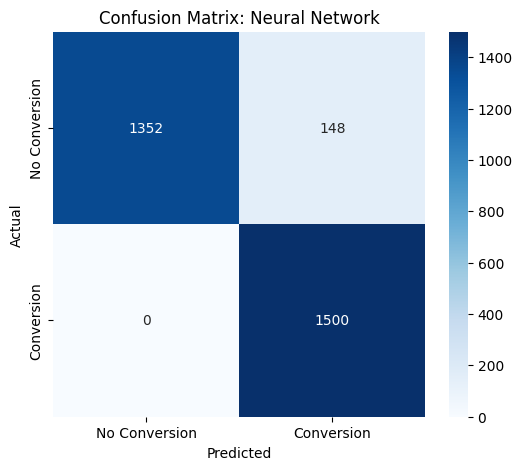

In [39]:
# Confusion Matrix
conf_matrix_nn = confusion_matrix(y_val, y_pred_nn)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Conversion', 'Conversion'], yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix: Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 5.1 Deployment preparation

In [40]:
import os
import joblib
from google.cloud import aiplatform
from tensorflow.keras.models import load_model

# Step 1: Save the model and preprocessing pipeline locally
print("Saving model and preprocessing pipeline...")
best_nn_model.save('best_nn_model.h5')  # Save the trained neural network model
joblib.dump(modeling_pipeline, 'preprocessing_pipeline.pkl')  # Save the preprocessing pipeline
print("Model and preprocessing pipeline saved successfully.")

# Step 2: Export the model to TensorFlow SavedModel format
print("Exporting model to TensorFlow SavedModel format...")
model = load_model('best_nn_model.h5')
model.save('saved_model_dir')  # Create SavedModel directory
print("Model exported successfully.")

# Step 3: Upload artifacts to Google Cloud Storage (GCS)
print("Uploading artifacts to GCS...")
model_gcs_path = 'gs://my-project-2025-447122-eu-notebooks/model/'
os.system(f"gsutil cp -r saved_model_dir {model_gcs_path}")
os.system(f"gsutil cp preprocessing_pipeline.pkl {model_gcs_path}")
print("Artifacts uploaded to GCS successfully.")

# Step 4: Initialize the Vertex AI environment
print("Initializing Vertex AI environment...")
aiplatform.init(
    project='my-project-2025-447122',  # Replace with your GCP project ID
    location='europe-west4'            # Replace with your GCP region
)

# Step 5: Upload the model to Vertex AI
print("Uploading model to Vertex AI...")
model = aiplatform.Model.upload(
    display_name='neural-network-model',  # Display name for the model in Vertex AI
    artifact_uri=f"{model_gcs_path}saved_model_dir",  # Path to the SavedModel in GCS
    serving_container_image_uri='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-8:latest',  # TensorFlow serving container
)
print(f"Model uploaded successfully: {model.resource_name}")

# Step 6: Deploy the model to an endpoint
print("Deploying model to an endpoint...")
endpoint = model.deploy(
    deployed_model_display_name='nn_model_endpoint',  # Name for the deployed model
    machine_type='n1-standard-4',                     # Machine type for hosting
)
print(f"Model deployed successfully: {endpoint.resource_name}")

print("Deployment preparation completed.")


Saving model and preprocessing pipeline...
Model and preprocessing pipeline saved successfully.
Exporting model to TensorFlow SavedModel format...


INFO:tensorflow:Assets written to: saved_model_dir/assets


INFO:tensorflow:Assets written to: saved_model_dir/assets


Model exported successfully.
Uploading artifacts to GCS...


Copying file://saved_model_dir/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://saved_model_dir/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://saved_model_dir/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://saved_model_dir/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [4 files][164.4 KiB/164.4 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://saved_model_dir/variables/variables.index [Content-Type=application/octet-stream]...
- [5 files][165.8 KiB/165.8 KiB]                                                
Operation completed over 5 objects/165.8 KiB.                                    
Copying file://prepr

Artifacts uploaded to GCS successfully.
Initializing Vertex AI environment...
Uploading model to Vertex AI...
Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/190053636941/locations/europe-west4/models/5156318108129951744/operations/4886211806772592640


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/190053636941/locations/europe-west4/models/5156318108129951744/operations/4886211806772592640


Model created. Resource name: projects/190053636941/locations/europe-west4/models/5156318108129951744@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/190053636941/locations/europe-west4/models/5156318108129951744@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/190053636941/locations/europe-west4/models/5156318108129951744@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/190053636941/locations/europe-west4/models/5156318108129951744@1')


Model uploaded successfully: projects/190053636941/locations/europe-west4/models/5156318108129951744
Deploying model to an endpoint...
Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320/operations/1474735089039441920


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320/operations/1474735089039441920


Endpoint created. Resource name: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/190053636941/locations/europe-west4/endpoints/3137533395672760320')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/190053636941/locations/europe-west4/endpoints/3137533395672760320')


Deploying model to Endpoint : projects/190053636941/locations/europe-west4/endpoints/3137533395672760320


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/190053636941/locations/europe-west4/endpoints/3137533395672760320


Deploy Endpoint model backing LRO: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320/operations/5949061318832029696


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320/operations/5949061318832029696


Endpoint model deployed. Resource name: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320


Model deployed successfully: projects/190053636941/locations/europe-west4/endpoints/3137533395672760320
Deployment preparation completed.


## 6. Send prediction request

In [46]:
import pandas as pd
import joblib
from google.cloud import aiplatform

# Initialize Vertex AI environment
aiplatform.init(project="my-project-2025-447122", location="europe-west4")

# Define endpoint and pipeline path
endpoint = aiplatform.Endpoint("projects/190053636941/locations/europe-west4/endpoints/3137533395672760320")
pipeline_path = "preprocessing_pipeline.pkl"  # Path to the preprocessing pipeline

# Step 1: Fetch and Prepare Data

# Selected features used during neural network training
selected_features = [
    'revenue_per_event', 'average_revenue', 'total_events',
    'average_session_duration', 'view_item_ratio', 'event_diversity_index',
    'session_id', 'days_since_first_event', 'average_session_events',
    'add_to_cart_ratio', 'active_days', 'days_since_last_session',
    'unique_items', 'weekend_activity', 'is_high_spender',
    'total_item_quantity'
]

def fetch_and_prepare_data(date):
    
    from google.cloud import bigquery
    
    client = bigquery.Client()
    
    query = f"""
    SELECT 
      event_date,
      event_timestamp,
      user_pseudo_id,
      event_name,

      ecommerce.total_item_quantity AS total_item_quantity,
      ecommerce.purchase_revenue_in_usd AS purchase_revenue_in_usd,
      ecommerce.purchase_revenue AS purchase_revenue,
      ecommerce.unique_items AS unique_items,
      ecommerce.transaction_id AS transaction_id,

      geo.country AS country,
      geo.city AS city,

      -- Flatten nested 'traffic_source' fields
      traffic_source.medium AS traffic_medium,
      traffic_source.source AS traffic_source

    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210120`
    WHERE event_date = '{date}'
    """

    query_job = client.query(query)
    df_pre = query_job.to_dataframe() #prediction df

    # Apply feature engineering
    df_pre = feature_engineering(df_pre)

    # Retain the target column for comparison
    target = 'conversion_within_7_days'
    df_pre_target = df_pre[target]  # Save the target column
    
    # Step 1: Limit the number of rows in the dataset
    max_rows = 5000  # Adjust this value based on your requirements and request size limits
    df_pre = df_pre.sample(n=max_rows, random_state=42)  # Randomly sample `max_rows` rows


    # only keep selected features
    selected_features_with_target = selected_features + [target]  # Include the target column
    df_pre = df_pre[selected_features_with_target]

    return df_pre

# Reuse your feature engineering functions
def feature_engineering(df_pre):
    df_pre = add_conversion_features(df_pre)  
    df_pre, session_features, user_session_features = add_session_features(df_pre)  # Unpack the tuple 
    df_pre = add_aggregates_features(df_pre)
    df_pre, bounce_rate, session_features, session_features_copy = add_behavioral_features(df_pre, session_features)
    df_pre = add_temporal_features(df_pre)
    df_pre = add_revenue_features(df_pre)
    
    return df_pre


# Step 2: Preprocess the Data

def preprocess_data(df, pipeline_path):
    """
    Preprocess the data using the saved preprocessing pipeline.
    """
    print("Loading preprocessing pipeline...")
    pipeline = joblib.load(pipeline_path)
    print("Preprocessing pipeline loaded successfully.")

    print("Transforming data...")
    prepared_data = pipeline.transform(df)
    print("Data transformation completed.")

    return prepared_data

# Step 3: Send Prediction Request

def send_prediction_request(prepared_data, endpoint):
    """
    Send the prepared data to the Vertex AI endpoint for prediction.
    """
    print("Sending data to the endpoint for prediction...")
    
    # Check if prepared_data is a sparse matrix
    if hasattr(prepared_data, "toarray"):
        # Convert sparse matrix to a dense array
        prepared_data = prepared_data.toarray()
    
    # Convert to a list for JSON serialization
    instances = prepared_data.tolist()
    response = endpoint.predict(instances=instances)
    print("Prediction completed.")
    return response.predictions

# Main Function

def main():
    # Define the prediction date
    prediction_date = "20210120"

    print(f"Fetching and preparing data for {prediction_date}...")
    raw_data = fetch_and_prepare_data(prediction_date)
    print(f"Raw data loaded with shape: {raw_data.shape}")

    print("Preprocessing data...")
    prepared_data = preprocess_data(raw_data, pipeline_path)
    print(f"Prepared data shape: {prepared_data.shape}")

    print("Sending prediction request...")
    predictions = send_prediction_request(prepared_data, endpoint)

    print("Adding predictions to the dataframe...")
    # Flatten predictions
    # because the predictions object returned from endpoint.predict(instances=instances) is a list of lists (where each sublist contains a single probability). 
    # When try to compare p > 0.5 in list comprehension, p is a list rather than a float.
    flat_predictions = [p[0] for p in predictions] 

    # Add predictions to the dataframe
    raw_data['predicted_probability'] = flat_predictions  # Save raw probabilities
    raw_data['predicted_class'] = [1 if p > 0.5 else 0 for p in flat_predictions]  # Apply threshold

    
    # Save results for comparison
    print("Comparison of actual vs. predicted:")
    print(raw_data[['conversion_within_7_days', 'predicted_class', 'predicted_probability']].head())
    
    # Save results to a CSV for analysis
    raw_data.to_csv('predictions_with_actuals.csv', index=False)
    print("Results saved to 'predictions_with_actuals.csv'.")

# Run the main function
if __name__ == "__main__":
    main()


Fetching and preparing data for 20210120...
Raw data loaded with shape: (5000, 17)
Preprocessing data...
Loading preprocessing pipeline...
Preprocessing pipeline loaded successfully.
Transforming data...
Data transformation completed.
Prepared data shape: (5000, 16)
Sending prediction request...
Sending data to the endpoint for prediction...
Prediction completed.
Adding predictions to the dataframe...
Comparison of actual vs. predicted:
       conversion_within_7_days  predicted_class  predicted_probability
27093                     False                0           4.799753e-03
11518                     False                0           1.127404e-10
12936                     False                1           8.887407e-01
27288                     False                0           4.797846e-03
52369                     False                1           8.626289e-01
Results saved to 'predictions_with_actuals.csv'.


## 7. Scoring of the model based on prediction

In [2]:
import pandas as pd
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved CSV file
df_results = pd.read_csv("predictions_with_actuals.csv")

# Ensure the necessary columns exist
assert 'conversion_within_7_days' in df_results.columns, "Actual target column missing!"
assert 'predicted_class' in df_results.columns, "Predicted class column missing!"
assert 'predicted_probability' in df_results.columns, "Predicted probability column missing!"

# Extract actual and predicted values
y_true = df_results['conversion_within_7_days']
y_pred = df_results['predicted_class']
y_prob = df_results['predicted_probability']

# Convert boolean `conversion_within_7_days` to integer if needed
if y_true.dtype == bool:
    y_true = y_true.astype(int)

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      4842
           1       0.18      1.00      0.31       158

    accuracy                           0.86      5000
   macro avg       0.59      0.93      0.61      5000
weighted avg       0.97      0.86      0.90      5000




Confusion Matrix:
[[4127  715]
 [   0  158]]


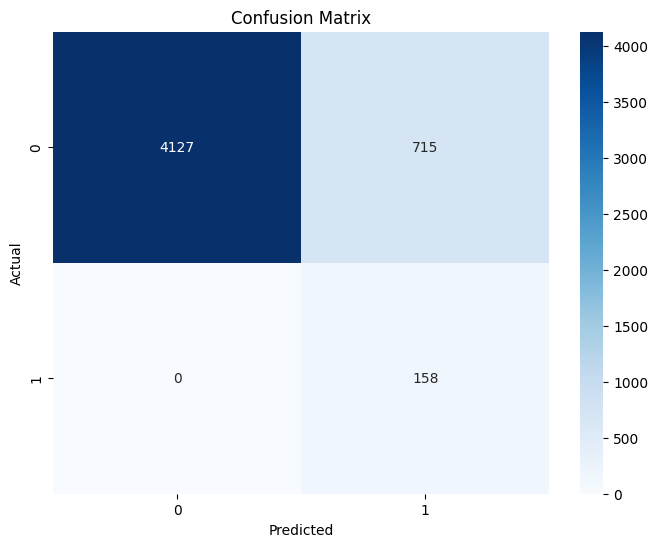

In [3]:
# 2. Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

AUC-ROC: 0.9943


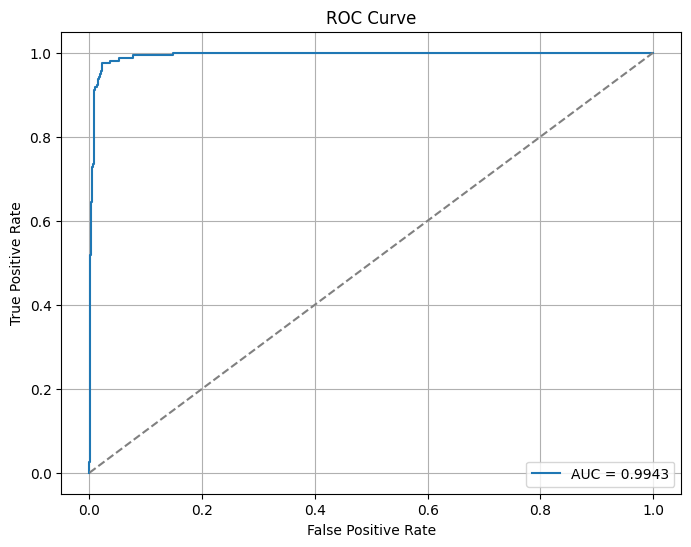

In [6]:
# 3. AUC-ROC Score
auc_score = roc_auc_score(y_true, y_prob)
print(f"AUC-ROC: {auc_score:.4f}")

# 4. Visualize AUC-ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()